# SVM Loan Approver

There are a number of classification algorithms that can be used to determine loan elgibility. Some algorithms run better than others. Build a loan approver using the SVM algorithm and compare the accuracy and performance of the SVM model with the Logistic Regression model.

In [731]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import style
style.use("ggplot")

In [732]:
#import Scikit Learn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D

In [1201]:
# Read in the data
# Note: The following data has been normalized between 0 and 1
data = Path('../Resources/loans.csv')
df = pd.read_csv(data)
X=df

## Separate the Features (X) from the Target (y)

In [1202]:
def get_binary(status):
    if status == 'deny':
        return 0
    else:
        return 1
    
X['binary'] = df.apply(lambda x: get_binary(x.status), axis=1)
c=X['binary']
Xf=X.drop('status', 1).drop('assets', 1).drop('mortgage', 1).drop('liabilities', 1).drop('binary', 1)
y=df.status

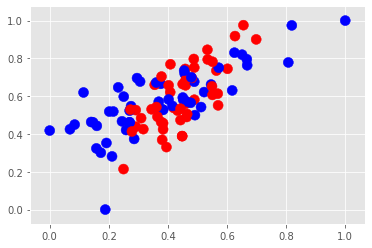

In [1209]:
plt.scatter(X['assets'], X['income'], c=c, s=100, cmap="bwr")
plt.show()

## Split our data into training and testing

In [939]:
# Use the train_test_split function to create training and testing subsets 
Xf_train, Xf_test, y_train, y_test = train_test_split(Xf, y, random_state=1, stratify=y)
Xf_train, Xf_test, c_train, c_test = train_test_split(Xf, c, random_state=1, stratify=y)


## Create a SVM Model

In [1284]:
# Instantiate a linear SVM model
model=SVC(kernel='linear', C=1)

## Fit (train) or model using the training data

In [1285]:
# Fit the data
clf=model.fit(Xf_train, y_train)

In [1286]:
# Plot the decision boundaries
x_min = X['income'].min() -2
x_max = X['income'].max() + 2
y_min = X['credit_score'].min() -2 
y_max = X['credit_score'].max() + 2
print(x_min, x_max, y_min, y_max)

-2.0 3.0 -2.0 3.0


In [1287]:
XX, YY = np.mgrid[x_min:x_max, y_min:y_max]
#print(XX)

In [1288]:
Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])
print(Z.shape)

(25,)


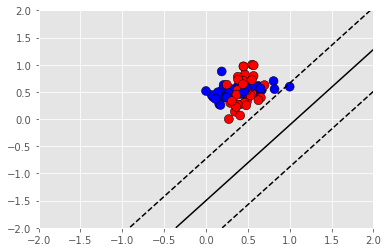

In [1289]:
Z = Z.reshape(XX.shape)
# plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
plt.scatter(X['assets'], X['credit_score'], c=c, cmap='bwr', edgecolor='k', s=80)
plt.show()

## Score the model using the test data

In [942]:
# Score the accuracy and print results
print("Trainig Data Score: " + f'{clf.score(Xf_train, y_train)}')
print("Testing Data Score: " + f'{clf.score(Xf_test, y_test)}')
#predictions = model.predict(X_test)

Trainig Data Score: 0.5131578947368421
Testing Data Score: 0.5384615384615384


In [1247]:
def svc_plot_3d(df, bin, cls):
    Xf=df.to_numpy()
    c=bin.to_numpy()
    clf=cls.predict(Xf)
    c = c[np.logical_or(c==0,c==1)]
    f=Xf[np.logical_or(c==0,c==1)]
    z = lambda x,y1: (-cls.intercept_[0]-cls.coef_[0][0]*x -cls.coef_[0][1]*y1) /cls.coef_[0][1]
    tmp = np.linspace(-0.25,1)
    x,y1= np.meshgrid(tmp,tmp)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(f[c==0,0] ,f[c==0,1], s=len(Xf))
    ax.scatter(f[c==1,0], f[c==1,1], s=len(Xf))
    ax.plot_surface(x, y1, z(x,y1))
    #ax.view_init(30, 45)
    return plt

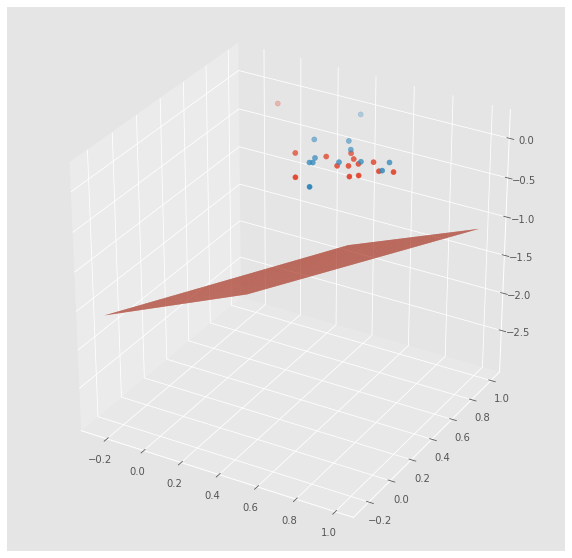

In [1290]:
plot_3d=svc_plot_3d(Xf_test, c_test, clf)
plot_3d.show()

## Make predictions

In [1058]:
pred_clf = model.predict(Xf_test)
loan_decision = pd.DataFrame({'Prediction': pred_clf, 'Actual': y_test}) 
loan_decision.head()

,Prediction,Actual
76,deny,deny
1,deny,approve
16,deny,deny
42,deny,deny
44,deny,deny


# Generate Confusion Matrix

In [671]:
c_matrix=pd.DataFrame(confusion_matrix(y_test, loan_decision['Prediction']), columns=['Predicted_No', 'Predicted_Yes'])
c_matrix.index=['Actual_No', 'Actual_Yes']
c_matrix

,Predicted_No,Predicted_Yes
Actual_No,1,11
Actual_Yes,1,13


# Generate Classification Report

In [672]:
labels=['Deny', 'Approve']
print(classification_report(y_test, loan_decision['Prediction'], target_names=labels))

              precision    recall  f1-score   support

        Deny       0.50      0.08      0.14        12
     Approve       0.54      0.93      0.68        14

    accuracy                           0.54        26
   macro avg       0.52      0.51      0.41        26
weighted avg       0.52      0.54      0.43        26



In [1027]:
def make_meshgrid(X0, X1, h=.01):
    x_min, x_max = X0.min() - 0.5, X0.max() + 0.5
    y_min, y_max = X1.min() - 0.5, X1.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [1023]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    for i in Z[0]:
        Z[Z==i]= get_binary(i)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [1065]:
def SVC_plot_2d(df, bins):
    c=bins
    Xf1=df.columns[0]
    Xf2=df.columns[1]
    fig, ax = plt.subplots()
    # title for the plots
    title = ("Decision surface of linear SVC")
    # Set-up grid for plotting.
    X0, X1 = df[Xf1].to_numpy(), df[Xf2].to_numpy()
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=c, cmap=plt.cm.coolwarm, s=50, edgecolors="k")
    ax.set_ylabel("{}".format(Xf1))
    ax.set_xlabel("{}".format(Xf2))
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    return plt

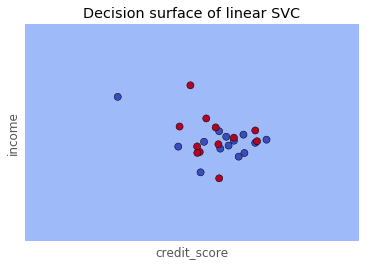

In [1291]:
plot_2d= SVC_plot_2d(Xf_test, c_test)
plot_2d.show()

In [1011]:
print("Trainig Data Score: " + f'{clf.score(Xf_train, y_train)}')
print("Testing Data Score: " + f'{clf.score(Xf_test, y_test)}')

Trainig Data Score: 0.5131578947368421
Testing Data Score: 0.5384615384615384


In [1252]:
def svc_hyperplane(cls):
# get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-0.25, 1)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin
    plt.figure(1, figsize=(5, 5))
    plt.clf()
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k-")
    plt.plot(xx, yy_up, "k-")
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
     facecolors="none", zorder=5, edgecolors="k")
    plt.scatter(X0, X1, c=c, zorder=5, cmap=plt.cm.Paired, edgecolors="k")
    plt.xlabel("x1")
    plt.ylabel("x2")
    return plt

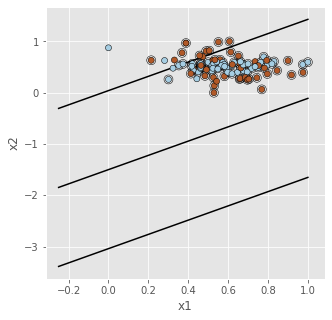

In [1292]:
hyper_plane = svc_hyperplane(clf)
hyper_plane.show()